In [ ]:
import pymatching as pm

pm.

Round 1 (Raw): [ True  True  True  True  True  True False  True False  True False  True
 False False False False False False False False False False False False]
Round 2 (Raw): [ True  True  True  True  True  True False  True False  True False  True
 False False False False False  True  True False False False False False]
Round 3 (Raw): [ True  True  True  True  True  True False  True False  True False  True
 False False False False False  True  True False False False False False]
Round 4 (Raw): [ True  True  True  True  True  True False  True False  True False  True
 False False False False False  True  True False False False False False]
Syndrome (1-2 Diff): [False False False False False False False False False False False False
 False False False False False  True  True False False False False False]
Syndrome (1-3 Diff): [False False False False False False False False False False False False
 False False False False False  True  True False False False False False]
Syndrome (1-4 Di

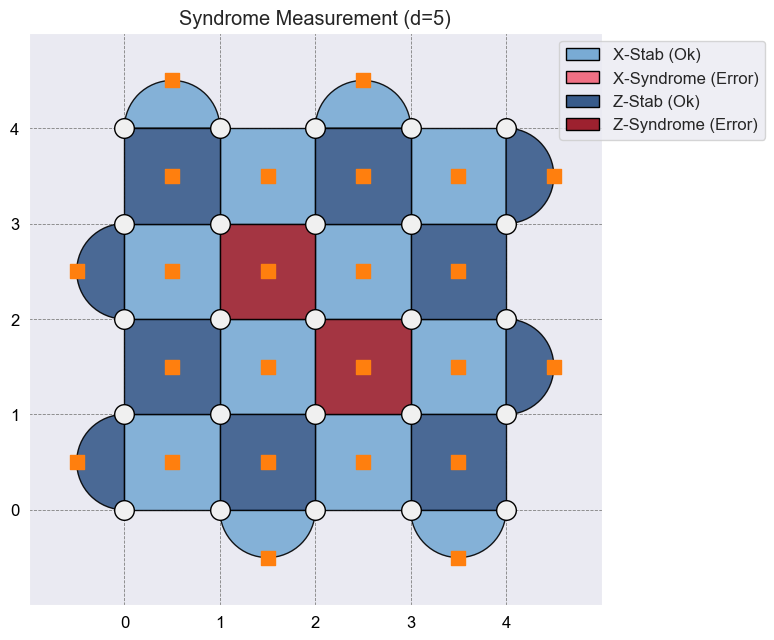

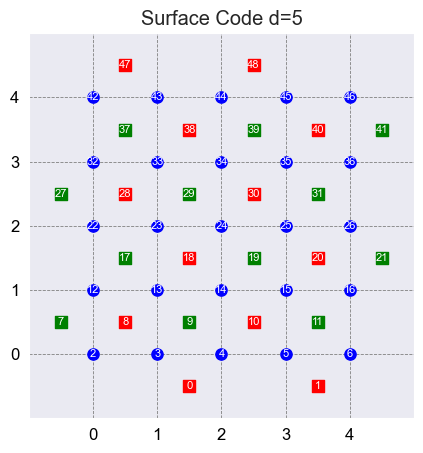

      /----------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\                                  /-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\
 q0: -QUBIT_COORDS(1.5,-0.5)---R---------------------------H-@-@-H-------------------------------------

In [ ]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)
sc.build_in_stim(rounds=4)

results = sc.run_simulation(shots=1)
single_shot = results[0]

# Calculate number of ancillas
num_ancillas = len(sc.x_stabilisers_coords) + len(sc.z_stabilisers_coords)

# Split results into rounds
round_1 = single_shot[:num_ancillas]
round_2 = single_shot[num_ancillas:2*num_ancillas]
round_3 = single_shot[2*num_ancillas:3*num_ancillas]
round_4 = single_shot[3*num_ancillas:4*num_ancillas]

syndrome_change = round_1 ^ round_2

print("Round 1 (Raw):", round_1)
print("Round 2 (Raw):", round_2)
print("Round 3 (Raw):", round_3)
print("Round 4 (Raw):", round_4)
print("Syndrome (1-2 Diff):", syndrome_change)
print("Syndrome (1-3 Diff):", round_1^round_3)
print("Syndrome (1-4 Diff):", round_1^round_4)

# Visualize the CHANGE, not the raw round
sc.visualize_results(round_1^round_2, show_ancillas=False)
sc.plot()
sc.diagram()

0 (1.5, -0.5) X_stab -> [(2.0, 0.0), (1.0, 0.0)]
inverse mapping: [(2.0, 0.0), (1.0, 0.0)] -> [4, 3]

1 (3.5, -0.5) X_stab -> [(4.0, 0.0), (3.0, 0.0)]
inverse mapping: [(4.0, 0.0), (3.0, 0.0)] -> [6, 5]

7 (-0.5, 0.5) Z_stab -> [(0.0, 1.0), (0.0, 0.0)]
inverse mapping: [(0.0, 1.0), (0.0, 0.0)] -> [12, 2]

8 (0.5, 0.5) X_stab -> [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)]
inverse mapping: [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)] -> [13, 12, 3, 2]

9 (1.5, 0.5) Z_stab -> [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)]
inverse mapping: [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)] -> [14, 4, 13, 3]

10 (2.5, 0.5) X_stab -> [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)]
inverse mapping: [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)] -> [15, 14, 5, 4]

11 (3.5, 0.5) Z_stab -> [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)]
inverse mapping: [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)] -> [16, 6, 15, 5]

17 (0.5, 1.5) Z_stab -> [(1.0, 2.0), (1.0, 1.0), (0.0, 2.0), (0

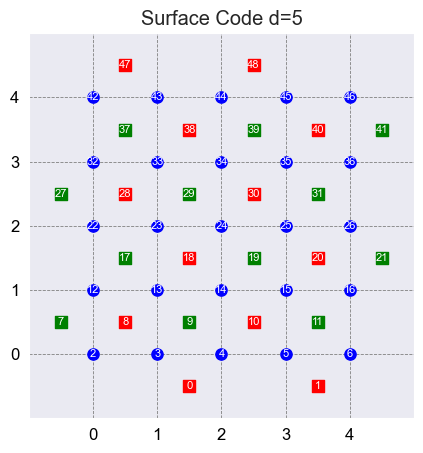

Sorted stabilizers:
8 ((0.5, 0.5), 'X_stab')
28 ((0.5, 2.5), 'X_stab')
47 ((0.5, 4.5), 'X_stab')
0 ((1.5, -0.5), 'X_stab')
18 ((1.5, 1.5), 'X_stab')
38 ((1.5, 3.5), 'X_stab')
10 ((2.5, 0.5), 'X_stab')
30 ((2.5, 2.5), 'X_stab')
48 ((2.5, 4.5), 'X_stab')
1 ((3.5, -0.5), 'X_stab')
20 ((3.5, 1.5), 'X_stab')
40 ((3.5, 3.5), 'X_stab')
7 ((-0.5, 0.5), 'Z_stab')
27 ((-0.5, 2.5), 'Z_stab')
17 ((0.5, 1.5), 'Z_stab')
37 ((0.5, 3.5), 'Z_stab')
9 ((1.5, 0.5), 'Z_stab')
29 ((1.5, 2.5), 'Z_stab')
19 ((2.5, 1.5), 'Z_stab')
39 ((2.5, 3.5), 'Z_stab')
11 ((3.5, 0.5), 'Z_stab')
31 ((3.5, 2.5), 'Z_stab')
21 ((4.5, 1.5), 'Z_stab')
41 ((4.5, 3.5), 'Z_stab')
Data qubits: [2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46]


In [4]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)

# Build circuit for 2 rounds to allow comparison
sc.build_in_stim(rounds=4)
all_ids = list(sc.index_mapping.keys())

for anc in all_ids:
    coord, qtype = sc.index_mapping[anc]
    if qtype == 'data':
        continue
    neigh = sc.get_surrounding_data_qubits(coord)
    print(anc, coord, qtype, '->', neigh)
    sc.inverse_mapping
    print(f"inverse mapping: {neigh} -> {[sc.inverse_mapping[n] for n in neigh]}\n")

sc.plot()

print("Sorted stabilizers:")
stab_indices = sc.get_stabilisers(_as="idx") # type: ignore
        
stab_indices = sorted(  # otherwise Z and X stabilizers are measured in random order!
    stab_indices,
    key=lambda anc: (
        sc.index_mapping[anc][1],        # 'X_stab' or 'Z_stab'
        sc.index_mapping[anc][0][0],     # x-coordinate
        sc.index_mapping[anc][0][1],     # y-coordinate
    )
)
for anc in stab_indices:
    print(anc, sc.index_mapping[anc])

data_indices = [k for k, v in sc.index_mapping.items() if v[1] == 'data']
print("Data qubits:", data_indices)


In [ ]:
from surface_code import SurfaceCode
print("--- Initializing SurfaceCode(distance=3) ---")
sc = SurfaceCode(distance=3)

test_instructions = [
    # ---------------------------
    # VALID INSTRUCTIONS
    # ---------------------------
    
    # 1. Standard Single Qubit Gate (Coordinates)
    # Applying H to data qubit at (0,0) and (1,0)
    {'operation': 'H', 'qubits': [(0, 0), (1, 0)]},

    # 2. Standard Single Qubit Gate (Indices)
    # Applying X to qubit index 0 and 2
    {'operation': 'X', 'qubits': [0, 2]},

    # 3. The 'all' keyword
    # Applying Z to all data qubits
    {'operation': 'Z', 'qubits': 'all'},

    # 4. CNOT with Coordinates
    # Control: (0,0), Target: (0,1)
    {'operation': 'CNOT', 'qubits': [((0, 0), (0, 1))]},

    # 5. CNOT with Indices
    # Control: Index 0, Target: Index 1
    {'operation': 'CNOT', 'qubits': [(0, 1)]},

    # 6. Ancilla Interaction (Float Coordinates)
    # Applying X to an ancilla at (0.5, 0.5)
    {'operation': 'X', 'qubits': [(0.5, 0.5)]},

    # ---------------------------
    # INVALID / MIXED INSTRUCTIONS (Should trigger Warnings)
    # ---------------------------

    # 7. Mixed Valid and Invalid Coordinates
    # (0,0) is valid. (99,99) is out of bounds. 
    # Result: Should save (0,0) and warn about (99,99).
    {'operation': 'H', 'qubits': [(0, 0), (99, 99)]},

    # 8. Mixed Valid and Invalid Indices
    # 0 is valid. 1000 is out of bounds.
    {'operation': 'Y', 'qubits': [0, 1000]},

    # 9. Misconception "invalid" CNOT Structure (Missing Target) but correctly formatted
    # Passed a single tuple instead of a tuple of tuples, but 0,0 are valid indices.
    # Result: Save 0,0, no warning, since it's valid.
    {'operation': 'CNOT', 'qubits': [(0, 0)]}, 

    # 10. Invalid CNOT Coordinates
    # One qubit is valid (0,0), one is invalid (99,99). 
    # The whole pair should be skipped.
    {'operation': 'CNOT', 'qubits': [((0, 0), (99, 99))]},
]

print("\n--- Running parse_instructions_new ---")
sc.parse_instructions_new(test_instructions)

print("\n--- Testing Fatal Error (Bad Operation Name) ---")
try:
    # This should raise an Assertion Error immediately
    sc.parse_instructions_new([{'operation': 'MAGIC_GATE', 'qubits': [(0,0)]}])
except AssertionError as e:
    print(f"Caught expected error: {e}")

print("\n--- FINAL PARSED INSTRUCTIONS ---")
for i, instr in enumerate(sc.instructions):
    print(f"{i}: Op: {instr['operation']} | Qubits: {instr['qubits']}")

Round 1 (Raw): [False False False False False False False False]
Round 2 (Raw): [False False False False False False False False]
Round 3 (Raw): [False False False False False False False False]
Round 4 (Raw): [False False False False False False False False]
Syndrome (Diff): [False False False False False False False False]


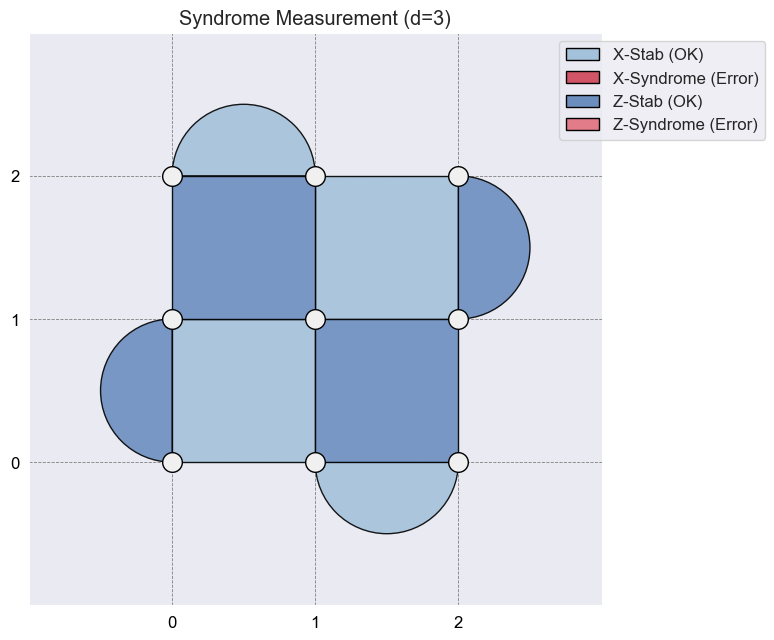

/----------------------\ /-\ /REP 4 /-----------------------------------------------------------------------------------------------------\ \
 q0: -QUBIT_COORDS(1.5,-0.5)-R-----|------R-@---@-----------------------------------------------------------------M:rec[0+iter*8]-----------------|-
                                   |        |   |                                                                                                 |
 q1: -QUBIT_COORDS(0,0)------R-X-Z-|--------|---|-H-X-H-------------------------------------@-----------------------------------------------------|-
                                   |        |   |   |                                       |                                                     |
 q2: -QUBIT_COORDS(1,0)------R-X-Z-|------H-X-H-|---|-----H-X-H-----------------------------|---@-------------------------------------------------|-
                                   |            |   |       |                               |   |                                                 |
 q3: -QUBIT_COORDS(2,0)------R-X-Z-|----------H-X-H-|-------|-------------------------------|---|---@---------------------------------------------|-
                                   |                |       |                               |   |   |                                             |
 q4: -QUBIT_COORDS(-0.5,0.5)-R-----|------R---------|-------|-------------------------------X-X-|---|-------------M:rec[4+iter*8]-----------------|-
                                   |                |       |                                 | |   |                                             |
 q5: -QUBIT_COORDS(0.5,0.5)--R-----|------R---------@---@---@---@-----------------------------|-|---|-------------M:rec[1+iter*8]-----------------|-
                                   |                    |       |                             | |   |                                             |
 q6: -QUBIT_COORDS(1.5,0.5)--R-----|------R-------------|-------|-----------------------------|-X-X-X-X-----------M:rec[5+iter*8]-----------------|-
                                   |                    |       |                             |   |   |                                           |
 q7: -QUBIT_COORDS(0,1)------R-X-Z-|------------------H-X-H-----|-----------------------------@---|---|-@-----------------------------------------|-
                                   |                            |                                 |   | |                                         |
 q8: -QUBIT_COORDS(1,1)------R-X-Z-|--------------------------H-X-H-H-X-H-------------------------@---|-|---@-------------------------------------|-
                                   |                                  |                               | |   |                                     |
 q9: -QUBIT_COORDS(2,1)------R-X-Z-|----------------------------------|-----H-X-H---------------------@-|---|---@---------------------------------|-
                                   |                                  |       |                         |   |   |                                 |
q10: -QUBIT_COORDS(0.5,1.5)--R-----|------R---------------------------|-------|-------------------------X-X-X-X-|-M:rec[6+iter*8]-----------------|-
                                   |                                  |       |                           |   | |                                 |
q11: -QUBIT_COORDS(1.5,1.5)--R-----|------R---------------------------@---@---@---@-----------------------|---|-|-M:rec[2+iter*8]-----------------|-
                                   |                                      |       |                       |   | |                                 |
q12: -QUBIT_COORDS(2.5,1.5)--R-----|------R-------------------------------|-------|-----------------------|---|-X-X---------------M:rec[7+iter*8]-|-
                                   |                                      |       |                       |   |   |                              

In [ ]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=3)

# Build circuit for 2 rounds to allow comparison
circuit = sc.build_in_stim(rounds=4)

# Run simulation
# We get a result of shape (shots, num_measurements)
# Total measurements = (num_ancillas) * rounds
results = sc.run_simulation(circuit, shots=1)
single_shot = results[0]

# Calculate number of ancillas
num_ancillas = len(sc.x_stabilisers_coords) + len(sc.z_stabilisers_coords)

# Split results into rounds
round_1 = single_shot[:num_ancillas]
round_2 = single_shot[num_ancillas:2*num_ancillas]
round_3 = single_shot[2*num_ancillas:3*num_ancillas]
round_4 = single_shot[3*num_ancillas:4*num_ancillas]

syndrome_change = round_1 ^ round_2

print("Round 1 (Raw):", round_1)
print("Round 2 (Raw):", round_2)
print("Round 3 (Raw):", round_3)
print("Round 4 (Raw):", round_4)
print("Syndrome (Diff):", syndrome_change)

# Visualize the CHANGE, not the raw round
sc.visualize_results(syndrome_change)
circuit.diagram()

In [ ]:
' Testing the instruction validation logic here '

from surface_code import SurfaceCode
sc = SurfaceCode(distance=3)

instructions = [...]

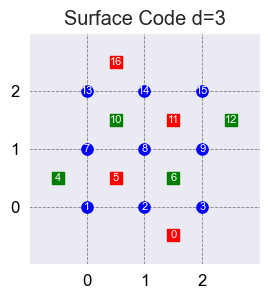

[[ True False False  True False False False False]
 [ True False False  True False False False False]
 [False False False False False False False False]
 [ True  True  True  True False False False False]
 [ True  True False False False False False False]
 [ True False False  True False False False False]
 [ True False  True False False False False False]
 [False False  True False False False False False]
 [False  True False  True False False False False]
 [False False False  True False False False False]]


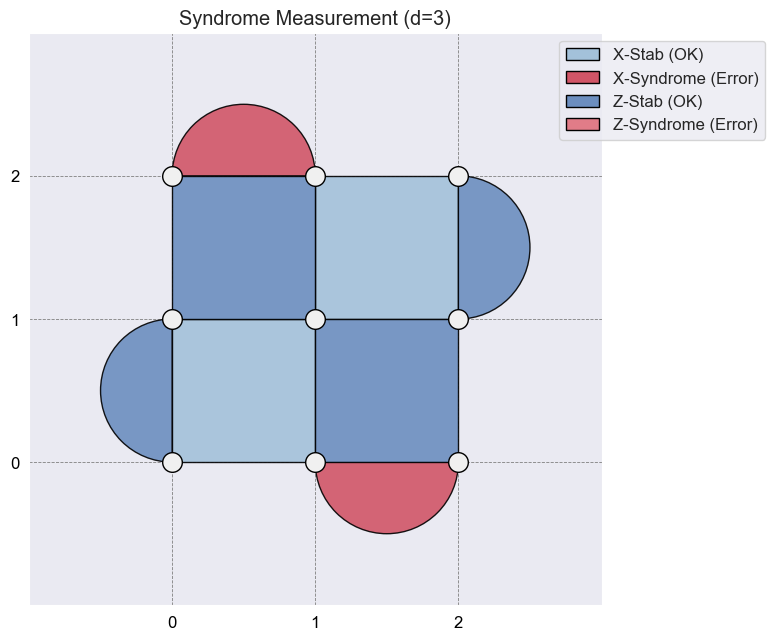

/----------------------\ /--------------------------------------------------------\
 q0: -QUBIT_COORDS(1.5,-0.5)-R-R-H-@-@-----------------------------------------H-M:rec[0]-
                                   | |
 q1: -QUBIT_COORDS(0,0)------R-----|-|-X-----------------@--------------------------------
                                   | | |                 |
 q2: -QUBIT_COORDS(1,0)------R-----X-|-|---X-------------|---@----------------------------
                                     | |   |             |   |
 q3: -QUBIT_COORDS(2,0)------R-------X-|---|-------------|---|---@------------------------
                                       |   |             |   |   |
 q4: -QUBIT_COORDS(-0.5,0.5)-R-R-------|---|-------------X-X-|---|---------------M:rec[4]-
                                       |   |               | |   |
 q5: -QUBIT_COORDS(0.5,0.5)--R-R-H-----@-@-@-@-------------|-|---|-------------H-M:rec[1]-
                                         |   |             | |   |
 q6: -QUBIT_COORDS(1.5,0.5)--R-R---------|---|-------------|-X-X-X-X-------------M:rec[5]-
                                         |   |             |   |   |
 q7: -QUBIT_COORDS(0,1)------R-----------X---|-------------@---|---|-@--------------------
                                             |                 |   | |
 q8: -QUBIT_COORDS(1,1)------R---------------X-X---------------@---|-|---@----------------
                                               |                   | |   |
 q9: -QUBIT_COORDS(2,1)------R-----------------|---X---------------@-|---|---@------------
                                               |   |                 |   |   |
q10: -QUBIT_COORDS(0.5,1.5)--R-R---------------|---|-----------------X-X-X-X-|---M:rec[6]-
                                               |   |                   |   | |
q11: -QUBIT_COORDS(1.5,1.5)--R-R-H-------------@-@-@-@-----------------|---|-|-H-M:rec[2]-
                                                 |   |                 |   | |
q12: -QUBIT_COORDS(2.5,1.5)--R-R-----------------|---|-----------------|---|-X-X-M:rec[7]-
                                                 |   |                 |   |   |
q13: -QUBIT_COORDS(0,2)------R-------------------|---|-X---------------@---|---|----------
                                                 |   | |                   |   |
q14: -QUBIT_COORDS(1,2)------R-------------------X---|-|-X-----------------@---|----------
                                                     | | |                     |
q15: -QUBIT_COORDS(2,2)------R-----------------------X-|-|---------------------@----------
                                                       | |
q16: -QUBIT_COORDS(0.5,2.5)--R-R-H---------------------@-@---------------------H-M:rec[3]-
      \----------------------/ \--------------------------------------------------------/

In [1]:
from surface_code import SurfaceCode

sc = SurfaceCode(distance=3)
sc.plot()

# print(sc.index_mapping)
# coords = (0.5,0.5)
# neighbors = sc.get_surrounding_data_qubits(coords)
# print(f"Neighbors of (0.5,0.5)/ index({sc.inverse_mapping[coords]}): ")
# for neigh in neighbors:
#     # find index of neigh
#     print(f" - {neigh} / index({sc.inverse_mapping[neigh]})")

circuit = sc.build_in_stim(rounds=1)

det = sc.run_simulation(circuit, shots=10)
print(det)
sc.visualize_results(det[0])

circuit.diagram()

In [ ]:
import stim

x_stabs = [0,5,11,16]
z_stabs = [4,6,10,12]

d_qbs = [1,2,3,7,8,9,13,14,15]

all_qbs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

patch1 = stim.Circuit()
patch1.append("R", all_qbs) # type: ignore

#NOTE: This serves as an error in the data qubits
patch1.append("X", d_qbs[0]) # type: ignore --> should give a syndrome in first stabilizer

### NOTE: Measure X stabilizers
for i, stab in enumerate(x_stabs):
    data_qubits_map = [
        [1,2], # anc 0
        [2,3,8,9], # anc 5
        [7,8,13,14], # anc 11
        [14,15] # anc 16
    ]
    targets = data_qubits_map[i]
    c_t_pairs = []
    for t in targets:
        c_t_pairs.append(t)
        c_t_pairs.append(stab)

    patch1.append("CNOT", c_t_pairs) # type: ignore

### NOTE: Measure Z stabilizers
for i, stab in enumerate(z_stabs):
    patch1.append("H", stab) # type: ignore
    data_qubits_map = [
        [1,2,7,8],
        [3,9],
        [7,13],
        [8,9,14,15]
    ]
    targets = data_qubits_map[i]
    c_t_pairs = []
    for t in targets:
        c_t_pairs.append(t)
        c_t_pairs.append(stab)
    patch1.append("CNOT", c_t_pairs) # type: ignore
    patch1.append("H", stab) # type: ignore

patch1.append("M", x_stabs+z_stabs) # type: ignore

smpl = patch1.compile_sampler()
result = smpl.sample(5)

def pprint(result):
    # create a stabilizer tableau
    print("Syndrome Results:")
    for r in result:
        print("[", end="")
        for bit in r[:(len(r)//2)]:
            print(0+bit, end='')
        print(" | ", end="")
        for bit in r[(len(r)//2):]:
            print(0+bit, end='')
        print("]", end="\n")
    print()

pprint(result)
patch1.diagram()

Syndrome Results:
[1000 | 0000]
[1000 | 0000]
[1000 | 0000]
[1000 | 0000]
[1000 | 0000]



q0: -R---X-X-----------------------------------------------------M:rec[0]----------
          | |
 q1: -R-X-@-|-------------------H---@-----------------------------------------------
            |                       |
 q2: -R-----@-@-----------------H-Z-|-@---------------------------------------------
              |                     | |
 q3: -R-------|-@---------------H---|-|-------@-------------------------------------
              | |                   | |       |
 q4: -R-------|-|-----------------H-X-X-X-X-H-|-------------------M:rec[4]----------
              | |                       | |   |
 q5: -R-------X-X-X-X-------------------|-|---|-------------------M:rec[1]----------
                  | |                   | |   |
 q6: -R-----------|-|-------------------|-|-H-X-X-H---------------M:rec[5]----------
                  | |                   | |     |
 q7: -R-----------|-|-@---------H-------@-|-----|---@-------------------------------
                  | | |                   |     |   |
 q8: -R-----------@-|-|-@-------H---------@-----|---|-----@-------------------------
                    | | |                       |   |     |
 q9: -R-------------@-|-|-------H---------------@---|-----|-@-----------------------
                      | |                           |     | |
q10: -R---------------|-|-------------------------H-X-X-H-|-|-----M:rec[6]----------
                      | |                             |   | |
q11: -R---------------X-X-X-X-------------------------|---|-|-----M:rec[2]----------
                          | |                         |   | |
q12: -R-------------------|-|-------------------------|-H-X-X-X-X-H--------M:rec[7]-
                          | |                         |       | |
q13: -R-------------------@-|---H---------------------@-------|-|-------------------
                            |                                 | |
q14: -R---------------------@-@-H-----------------------------@-|-------------------
                              |                                 |
q15: -R-----------------------|-@-H-----------------------------@-------------------
                              | |
q16: -R-----------------------X-X---------------------------------M:rec[3]----------

In [204]:
import stim
import numpy as np

def get_coords(d, patch_offset_x=0):
    """
    Generate coordinates for data qubits in a rotated surface code.
    Returns a dict mapping (row, col) to a flat qubit index.
    """
    coords = {}
    # Create d x d data qubit grid
    for r in range(d):
        for c in range(d):
            # We add a large offset to the second patch to keep indices distinct
            flat_index = r * d + c + patch_offset_x
            coords[(r, c)] = flat_index
    return coords

def generate_transversal_cnot_experiment(distance=3):
    d = distance
    # 1. Define Qubit Indices
    # Patch 1 (Control) starts at index 0
    # Patch 2 (Target) starts at index 100 (arbitrary offset)
    p1_coords = get_coords(d, patch_offset_x=0)
    p2_coords = get_coords(d, patch_offset_x= 2 * distance ** 2  + 10) # Ensure no overlap

    circuit = stim.Circuit()

    # -------------------------------------------------------------
    # 2. Initialization
    # Initialize Patch 1 in |+> (Control for CNOT) and Patch 2 in |0> (Target)
    # (Simplified: In a real QEC experiment you'd do noisy init + stabilizer rounds)
    # -------------------------------------------------------------
    all_p1 = sorted(p1_coords.values())
    all_p2 = sorted(p2_coords.values())
    
    circuit.append("R", all_p1 + all_p2) # Reset all
    circuit.append("H", all_p1)          # Prepare P1 in |+> (X basis)

    # -------------------------------------------------------------
    # 3. Inject the "Single Error" You Requested
    # We put an X error on a data qubit in the Control Patch (P1)
    # This should propagate to the Target Patch (P2)
    # -------------------------------------------------------------
    target_data_qubit = p1_coords[(1, 1)] # Center qubit of patch 1
    # We use X_ERROR to simulate a physical error mechanism
    circuit.append("X_ERROR", [target_data_qubit], 1.0) 

    # -------------------------------------------------------------
    # 4. Transversal CNOT
    # Apply physical CNOTs between corresponding qubits (r,c) in P1 and P2
    # -------------------------------------------------------------
    for r in range(d):
        for c in range(d):
            ctrl = p1_coords[(r, c)]
            targ = p2_coords[(r, c)]
            circuit.append("CNOT", [ctrl, targ])

    # -------------------------------------------------------------
    # 5. Measurement (Ideal Stabilizer Checks)
    # In a full simulation, you would measure stabilizers here.
    # For this demo, we verify propagation by measuring data qubits directly.
    # -------------------------------------------------------------
    # We measure Control in X basis (H then M) to see if the X error stayed
    # We measure Target in Z basis (M) to see if the X error arrived (X flips Z)
    # circuit.append("H", all_p1) # Switch P1 back to Z basis for measurement
    circuit.append("M", all_p1)
    circuit.append("M", all_p2)

    return circuit, p1_coords, p2_coords

# Run the simulation
d = 3
circuit, p1, p2 = generate_transversal_cnot_experiment(d)
sampler = circuit.compile_sampler()
result = sampler.sample(shots=1) # [0]
print(result.shape)
result = result[0]
# Parse Results
# We expect the error at (1,1) in Patch 1 to show up in measurements
# And also at (1,1) in Patch 2 because CNOT propagates X -> X
p1_offset = 0
p2_offset = len(p1)

print(f"Injecting X error at P1 coords (1,1)...")
print("-" * 30)
print("Patch 1 (Control) Measurements (Expected: 1 at 1,1):")
for r in range(d):
    row_vals = []
    for c in range(d):
        # The measurement index corresponds to the sorted order of qubits
        meas_idx = (r * d + c) 
        val = int(result[meas_idx])
        row_vals.append(str(val))
    print(" ".join(row_vals))

print("\nPatch 2 (Target) Measurements (Expected: 1 at 1,1):")
for r in range(d):
    row_vals = []
    for c in range(d):
        meas_idx = (r * d + c) + len(p1)
        val = int(result[meas_idx])
        row_vals.append(str(val))
    print(" ".join(row_vals))

print("-" * 30)
print("VERIFICATION: The error appeared in BOTH patches.")

(1, 18)
Injecting X error at P1 coords (1,1)...
------------------------------
Patch 1 (Control) Measurements (Expected: 1 at 1,1):
1 1 1
1 0 0
1 0 1

Patch 2 (Target) Measurements (Expected: 1 at 1,1):
1 1 1
1 0 0
1 0 1
------------------------------
VERIFICATION: The error appeared in BOTH patches.


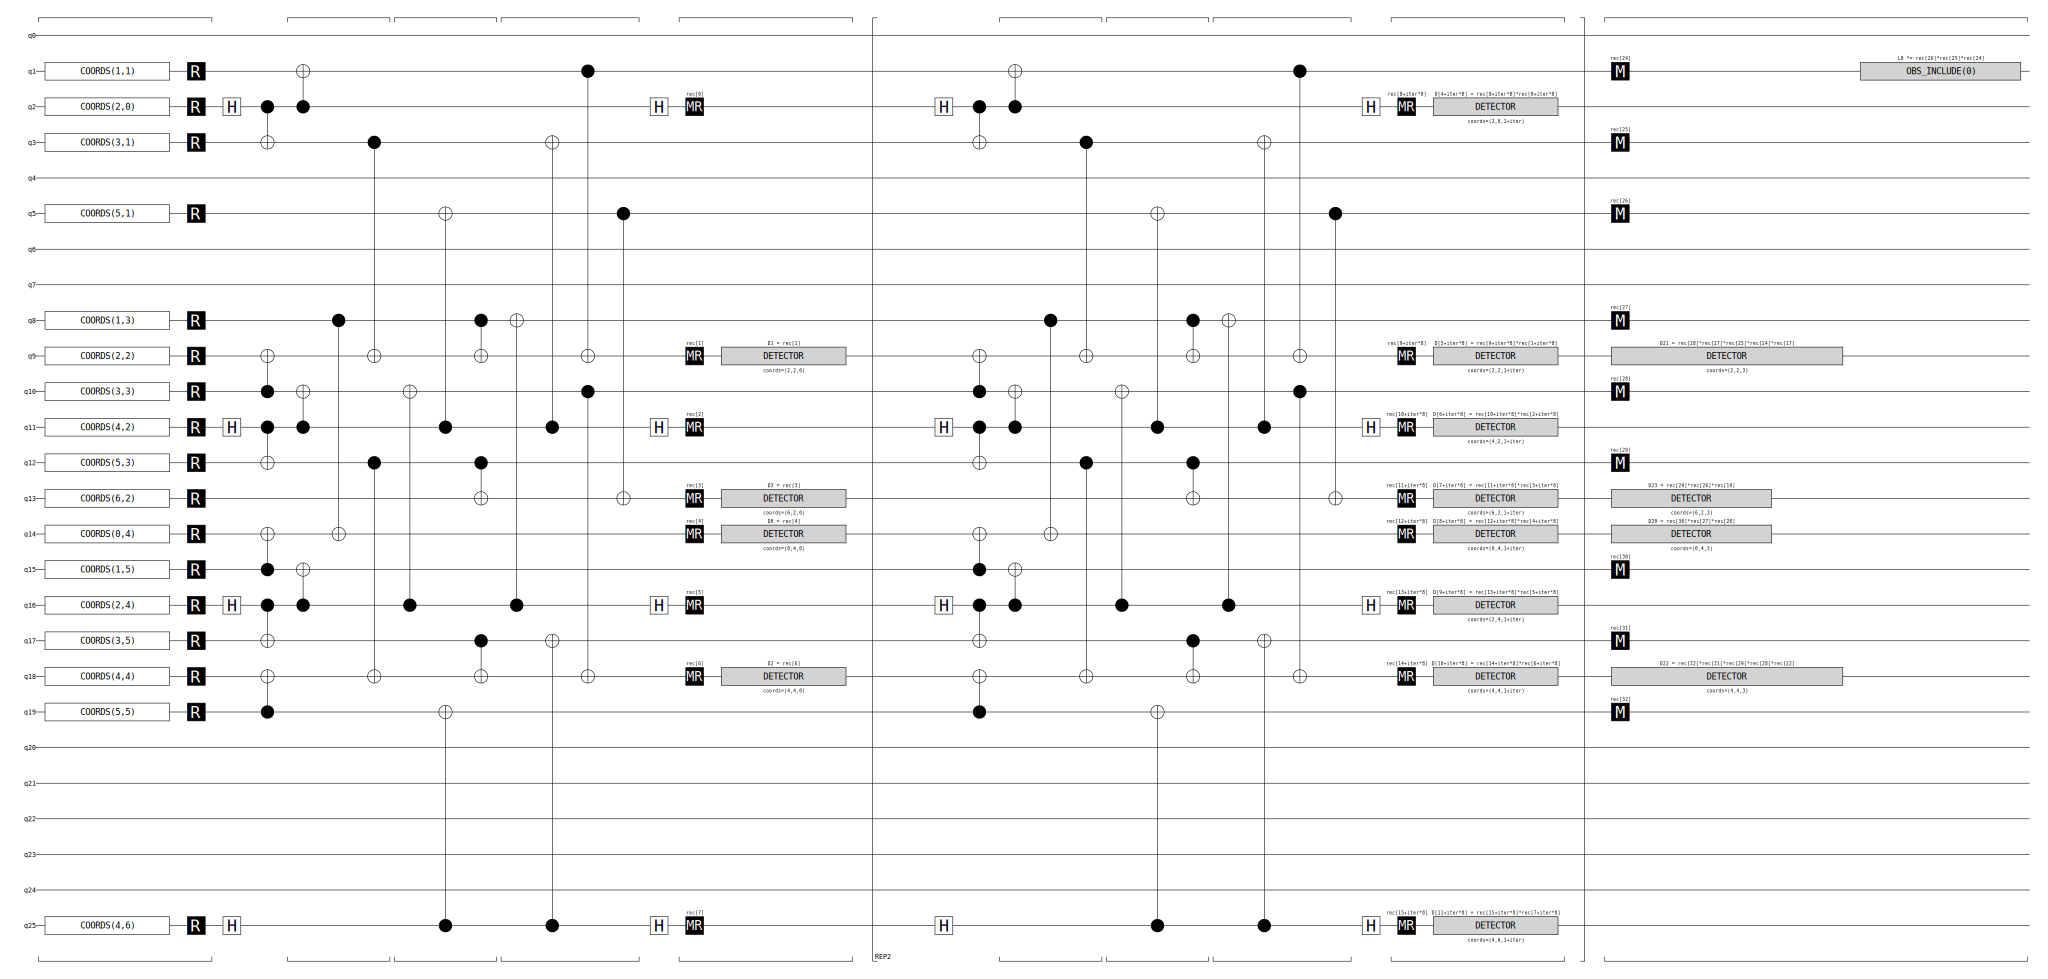

In [2]:
import stim
import numpy as np
from build_circuit import build_circuit, create_clean_circuit, apply_noise
from combine_circuits import combine_circuits_parallel


distance = 3
rounds = distance
p_meas = 1e-3
p_gate = 1e-3
p_idle = 0
p_cnot = 0

Instructions_on_logical_bits = [
    ("H", [0]),
    ("CX", [0, 1]),
    ("M", [0,1]),
]
# Two logical qubits
left_q = create_clean_circuit(distance, rounds)
right_q = create_clean_circuit(distance, rounds)

# Create combined clean circuit
combined_clean = combine_circuits_parallel(left_q, right_q)

# left_q.diagram('timeline-svg')
right_q.diagram('timeline-svg')
# Has to build 2 independent circuits and combine them in parallel
# I need to encode somehow how the gates are applied in each circuit and how to build
# the 2 qubit gates across circuits (or rather how that is done in the combined circuit)
# which should be just applying CNOT across the shifted indices
# circ = build_circuit() # type:ignore 

# So I still need a function that performs the operations on the logical qubits/patches

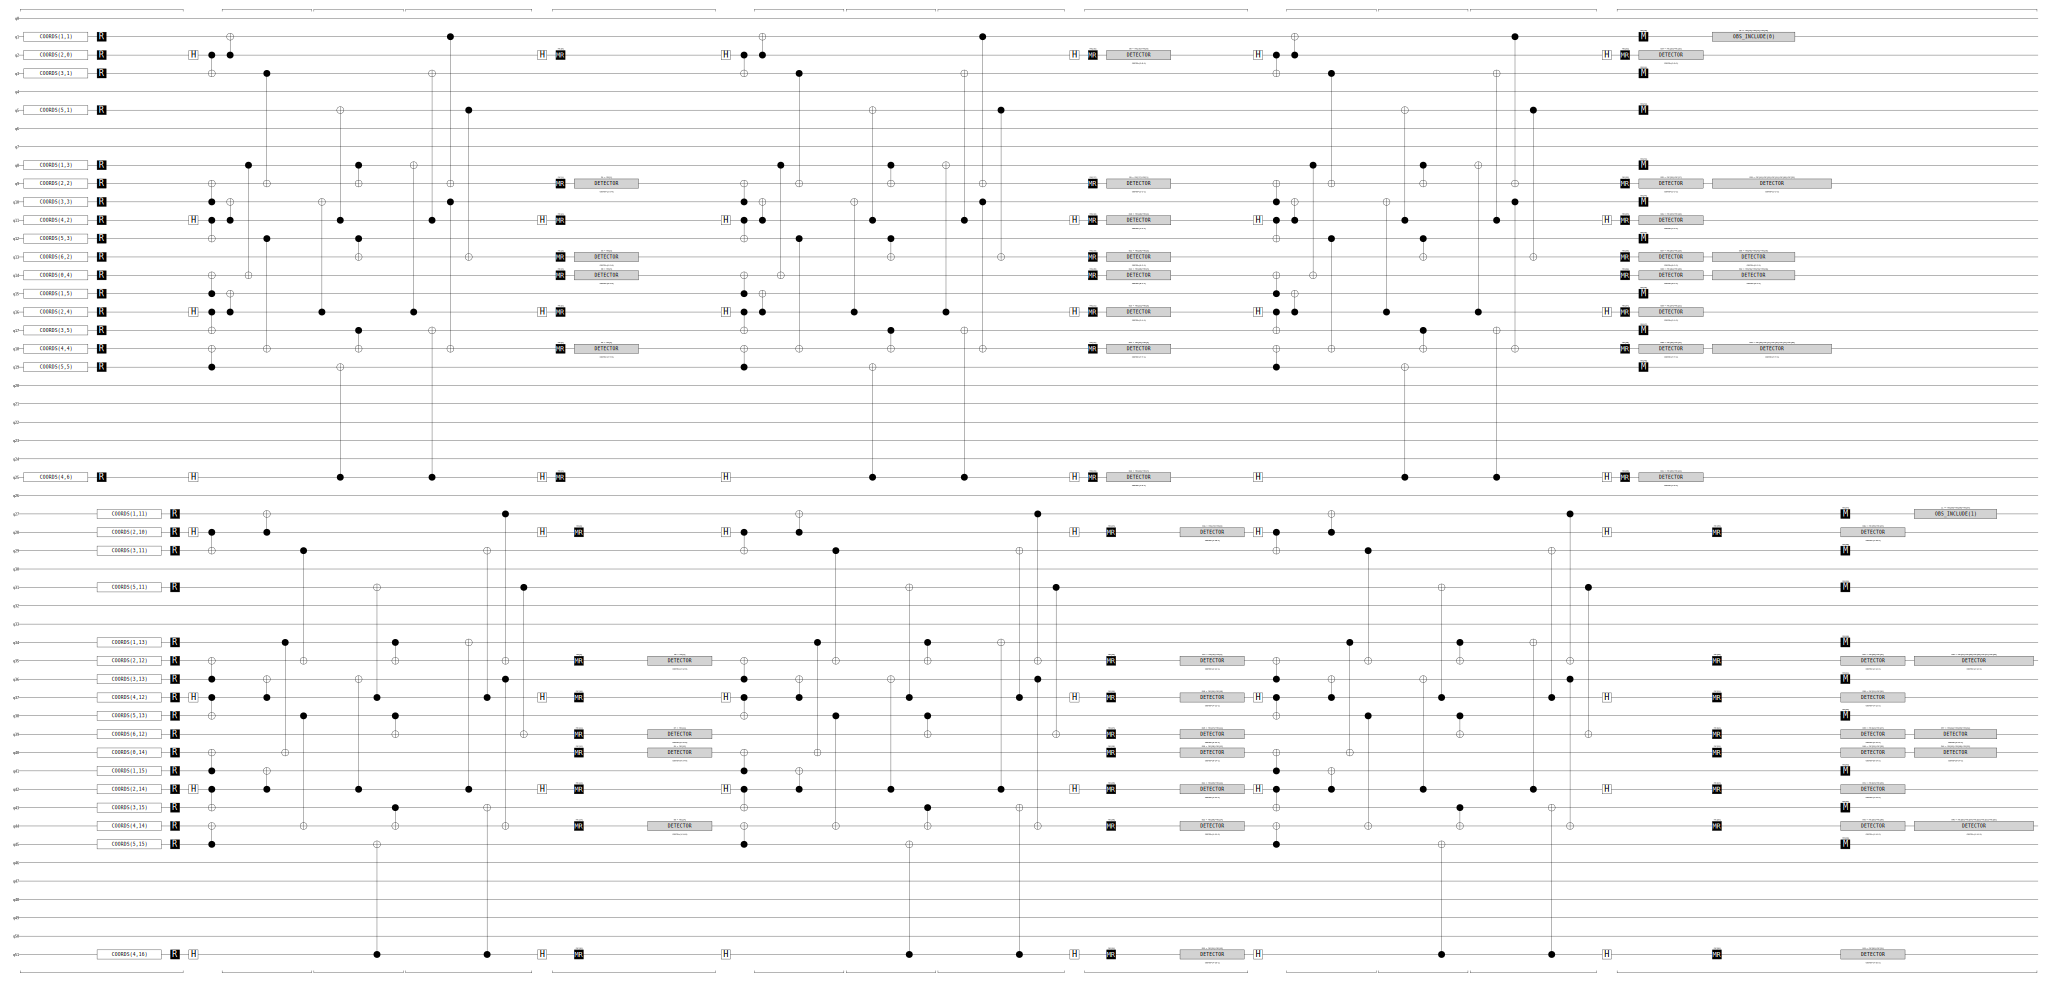

In [3]:
combined_clean.diagram('timeline-svg')

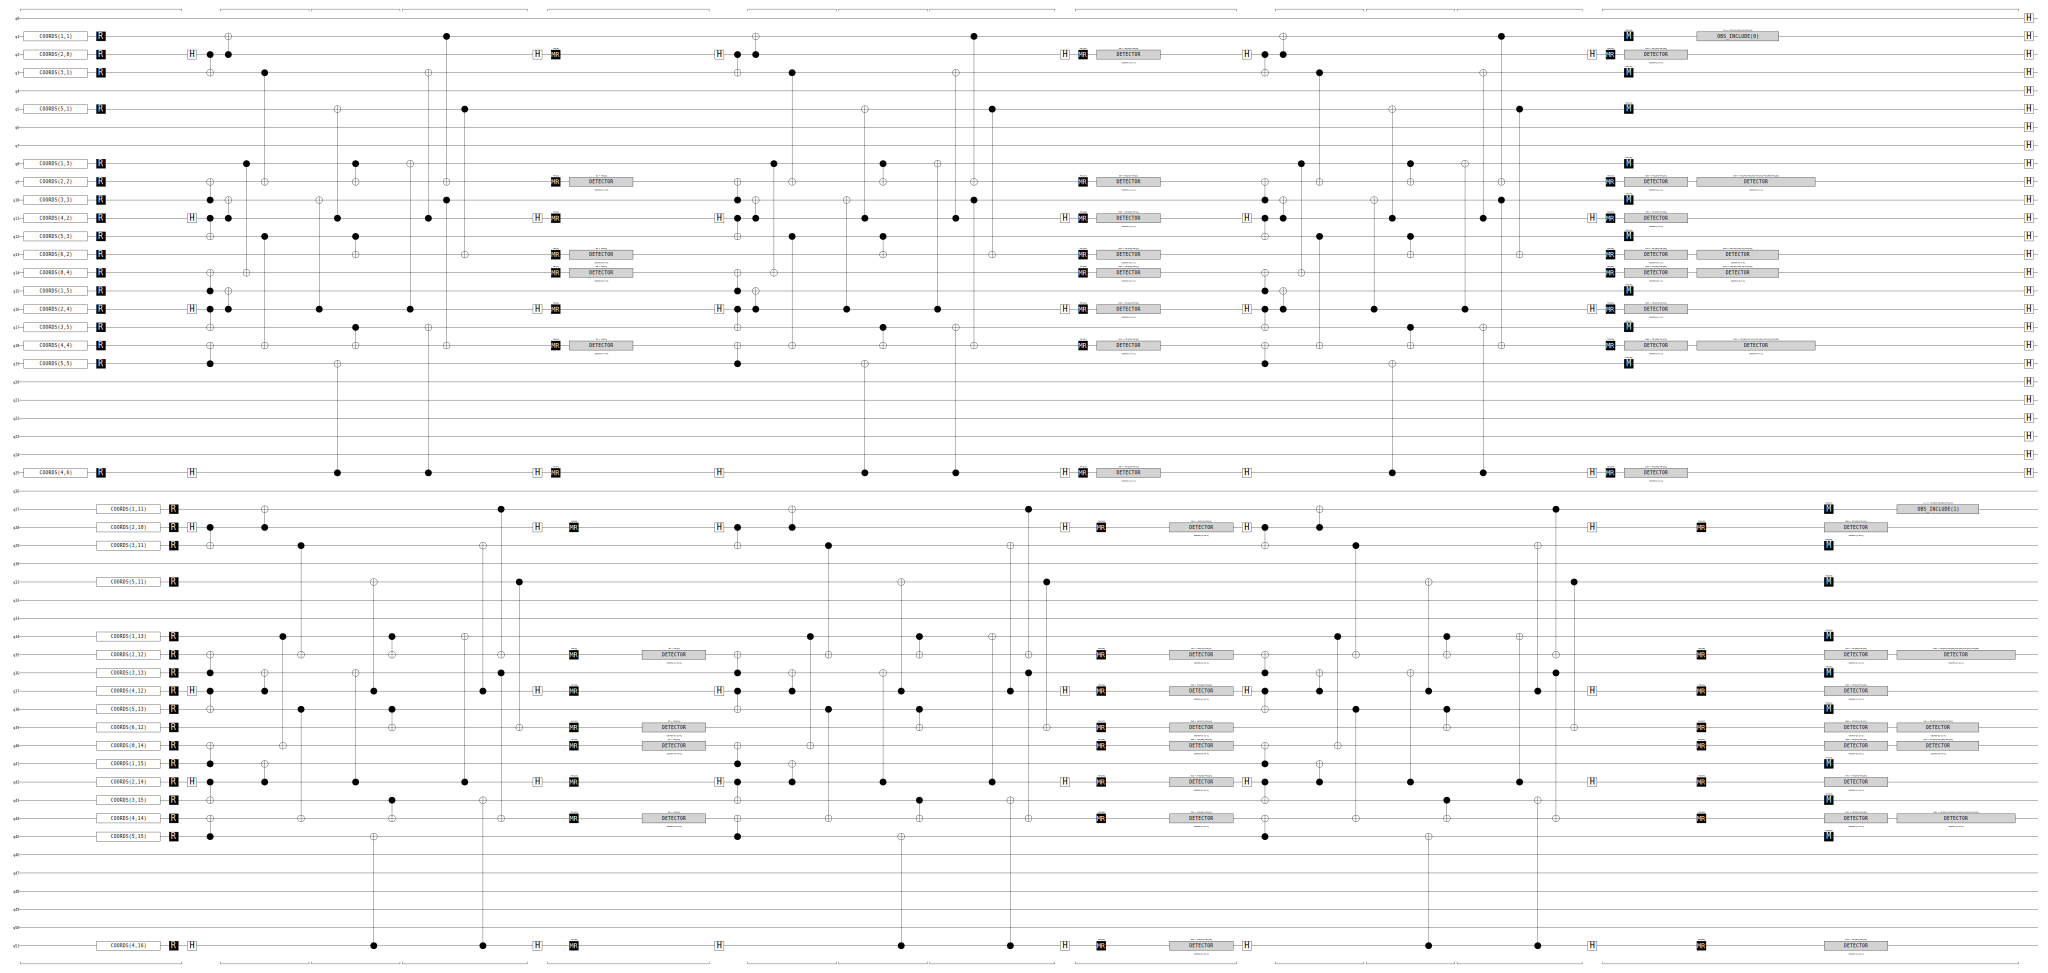

In [4]:
# Apply hadamard on logical qubit 0
for target in range(combined_clean.num_qubits//2):
    combined_clean.append("H", [target])  # type: ignore

combined_clean.diagram('timeline-svg')

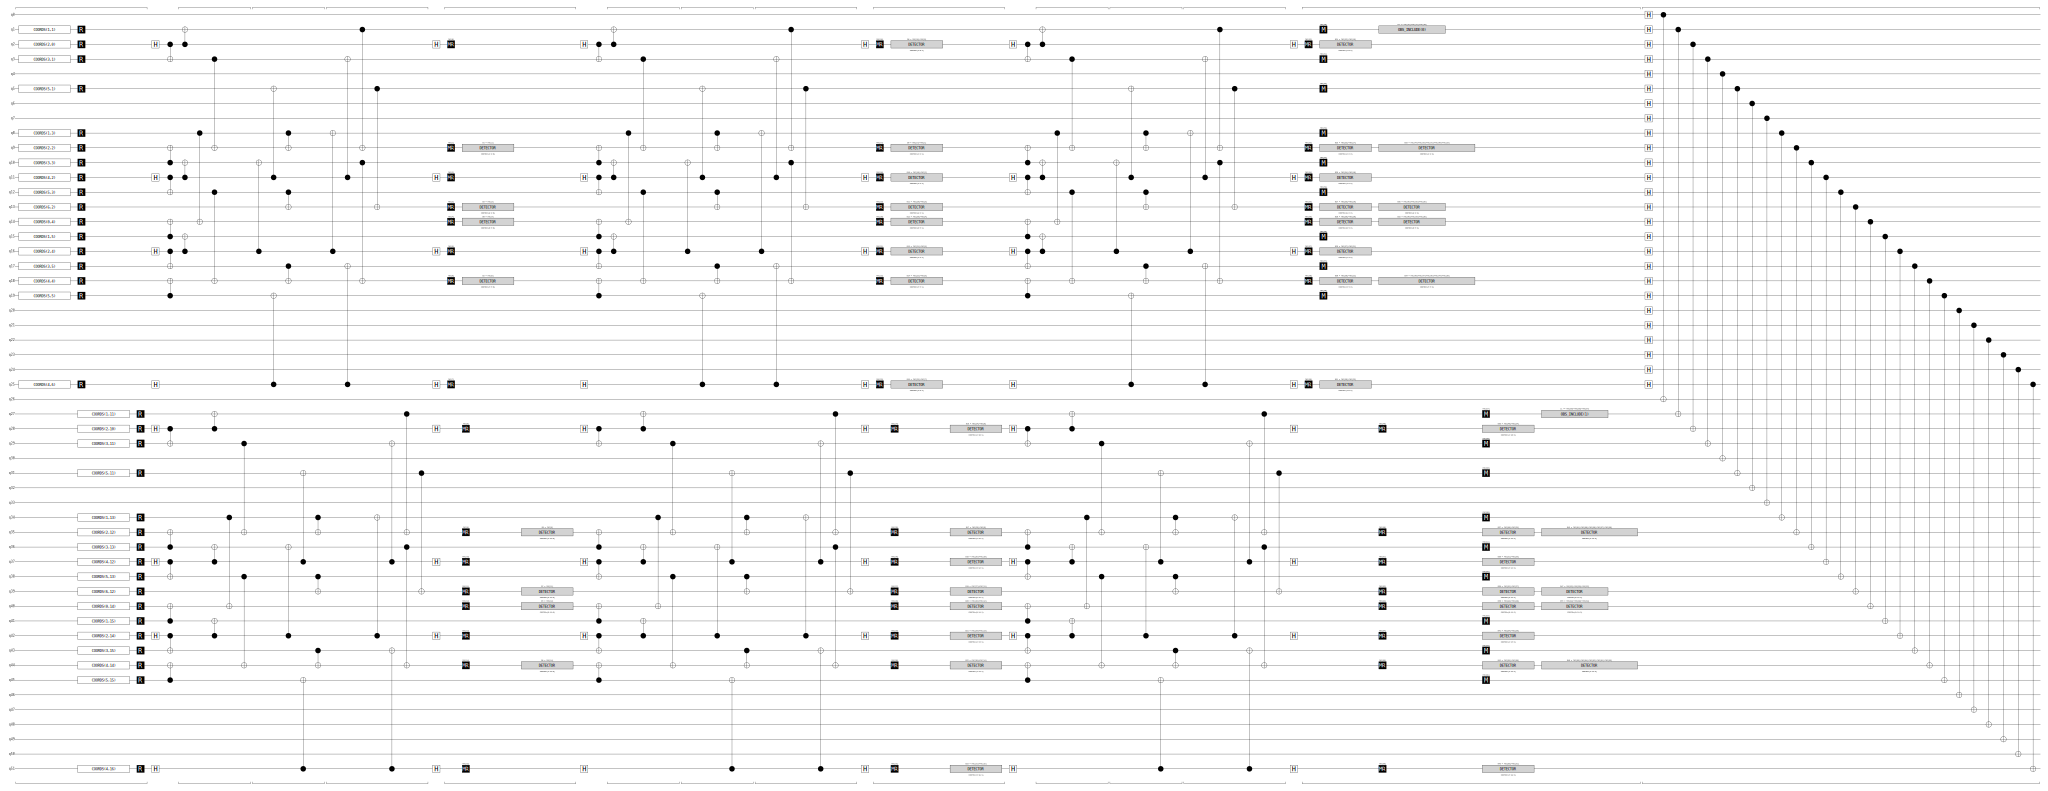

In [5]:
# Now apply CNOT between logical qubit 0 and 1
for target in range(combined_clean.num_qubits//2):
    combined_clean.append("CX", [target, target + combined_clean.num_qubits//2])  # type: ignore
combined_clean.diagram('timeline-svg')

In [25]:
distance = 3
rounds = 1
p_meas = 0 # No internal noise for this test
p_gate = 0
p_idle = 0
p_cnot = 0
p_logical_x_flip = 0.20 # 20% X error rate for the logical test

left_q = create_clean_circuit(distance, rounds)
right_q = create_clean_circuit(distance, rounds)

combined_clean = combine_circuits_parallel(left_q, right_q)
num_data_qubits_per_code = left_q.num_qubits

combined_clean.append("H", range(num_data_qubits_per_code))  # type: ignore

# Apply logical CNOT (Control Q0, Target Q1)
# Transversal CNOT between data qubits at corresponding indices
targets = []
for i in range(num_data_qubits_per_code):
    targets.extend([i, i + num_data_qubits_per_code])

combined_clean.append("CX", targets)  # type: ignore

combined_clean.append("X_ERROR", range(combined_clean.num_qubits), p_logical_x_flip)
combined_clean.append("TICK")  # type: ignore
combined_clean.append("M", range(combined_clean.num_qubits)) # type: ignore

final_circuit = combined_clean
shots = 10000
print(f"number of qubits in final circuit: {final_circuit.num_qubits}")
# --- Simulation and Separation ---

sampler = final_circuit.compile_detector_sampler()
observables_raw = sampler.sample(shots=shots)#[:, final_circuit.num_detectors:]  # type: ignore

print(observables_raw.shape)
print(observables_raw)
logical_qubit_0_results = observables_raw[:, 0]
logical_qubit_1_results = observables_raw[:, 1]

error_rate_q0 = np.mean(logical_qubit_0_results)
error_rate_q1 = np.mean(logical_qubit_1_results)

correlation = np.mean(logical_qubit_0_results * logical_qubit_1_results)


print(f"--- Logical Simulation Results (Shots: {shots}) ---")
print(f"Injected X flip probability (P_X): {p_logical_x_flip:.3f}")
print(f"")
print(f"Logical Qubit 0 Error Rate (X-basis flip): {error_rate_q0:.4f}")
print(f"Logical Qubit 1 Error Rate (X-basis flip): {error_rate_q1:.4f}")
print(f"")
print(f"Expected Error Rate (P_X): {p_logical_x_flip:.4f}")
print(f"")
print(f"Q0 and Q1 Error Correlation (P(Q0=1 and Q1=1)): {correlation:.4f}")

number of qubits in final circuit: 52
(10000, 16)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
--- Logical Simulation Results (Shots: 10000) ---
Injected X flip probability (P_X): 0.200

Logical Qubit 0 Error Rate (X-basis flip): 0.0000
Logical Qubit 1 Error Rate (X-basis flip): 0.0000

Expected Error Rate (P_X): 0.2000

Q0 and Q1 Error Correlation (P(Q0=1 and Q1=1)): 0.0000


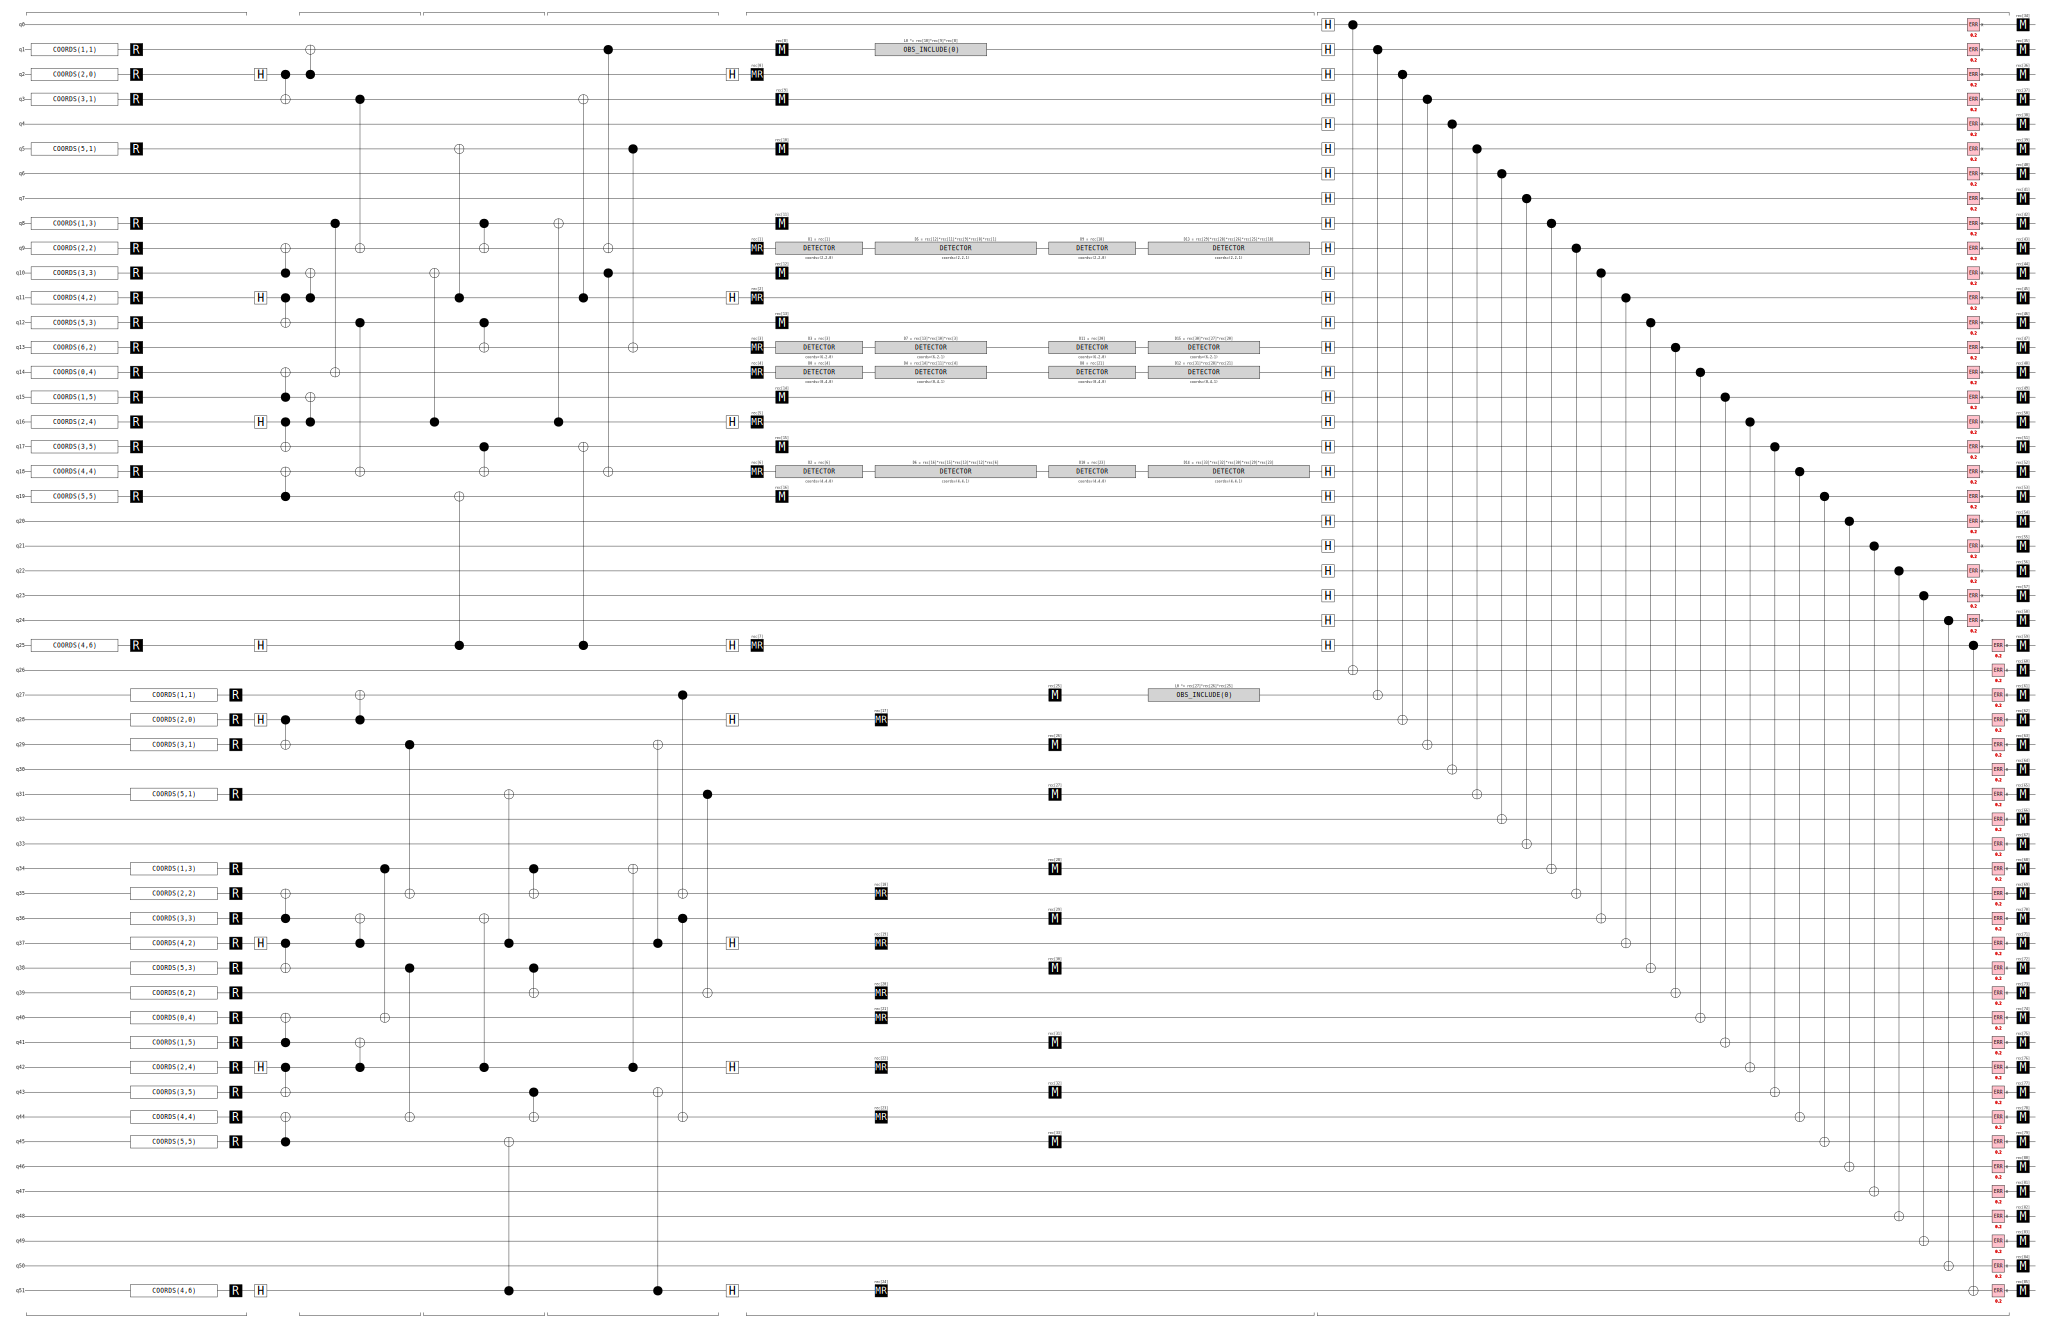

In [26]:
combined_clean.diagram('timeline-svg')

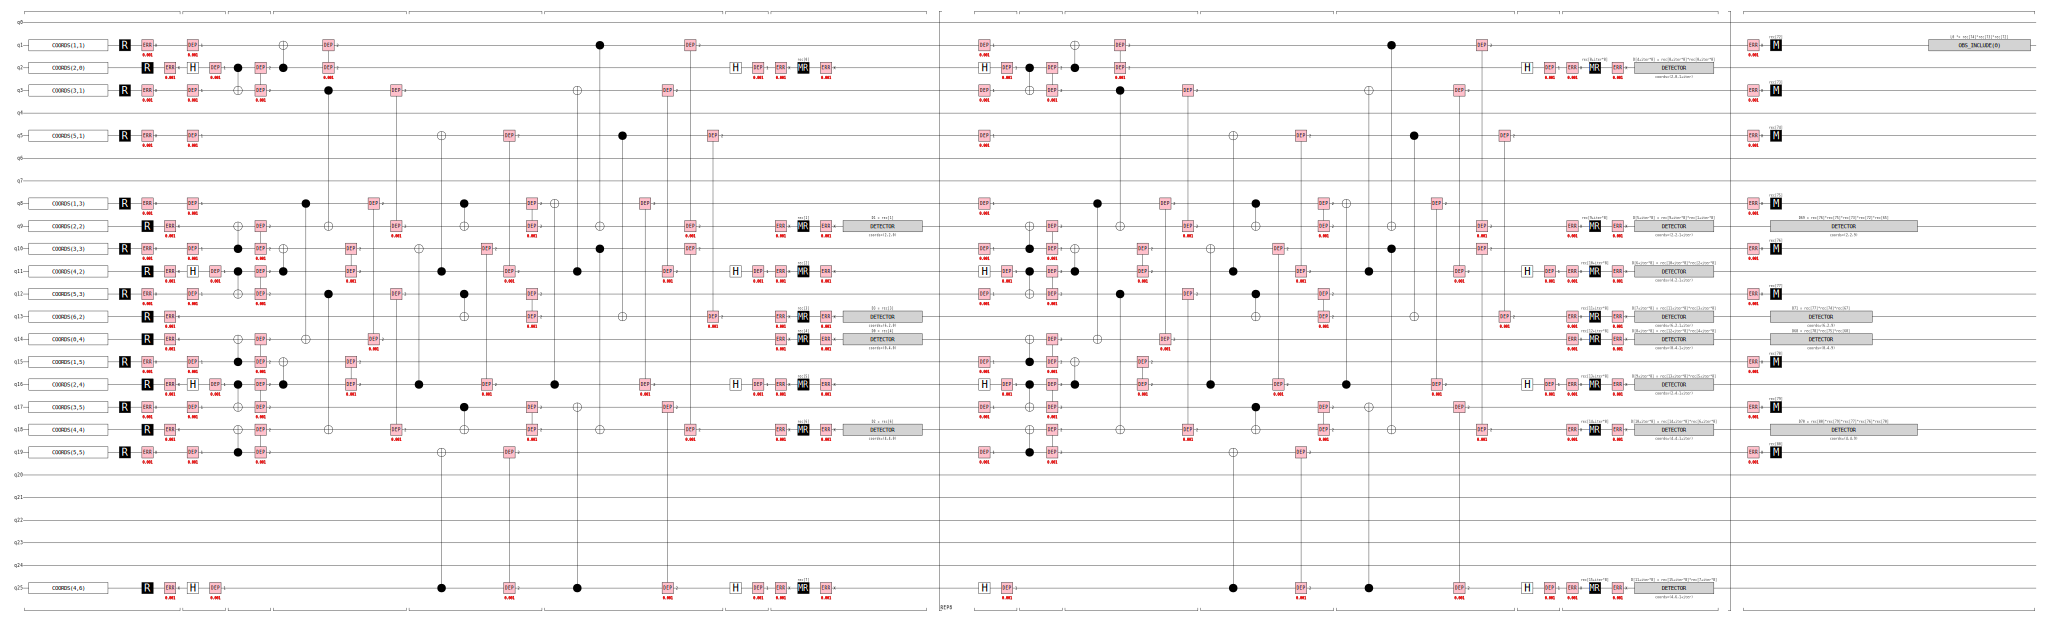

In [27]:
# For initialization error use something like this instead:
d = 3
noise = 1e-3
c = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        )
c.diagram('timeline-svg')

In [2]:
"""
I need to figure out which of these qubits the actual ancilla qubits are on which I would measure the errors.
I need to also understand how the circuit is in th end modeled and how I would get some errornous result -
so the actual simulated stuff. After that I can think about the decoding, but this is more important for now.
I will make this my todo for next tuesday and then see about wednesday and thursday.

"""

'\nI need to figure out which of these qubits the actual ancilla qubits are on which I would measure the errors.\nI need to also understand how the circuit is in th end modeled and how I would get some errornous result -\nso the actual simulated stuff. After that I can think about the decoding, but this is more important for now.\nI will make this my todo for next tuesday and then see about wednesday and thursday.\n\n'

In [24]:
import stim
import numpy as np

def create_clean_circuit(distance: int, rounds: int) -> stim.Circuit:
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=0,
        after_reset_flip_probability=0,
        before_measure_flip_probability=0,
        before_round_data_depolarization=0
    )

def apply_noise(circuit: stim.Circuit, p_gate: float, p_meas: float, p_idle: float, p_cnot: float) -> stim.Circuit:
    noisy_circuit = stim.Circuit()
    single_qubit_gates = {"H"}
    two_qubit_gates = {"CX", "CNOT"}
    measure_gates = {"M", "MR", "MX", "MY", "MZ"}
    for instruction in circuit:
        noisy_circuit.append(instruction)
        name = instruction.name
        targets = instruction.targets_copy()
        if name in measure_gates:
            if p_meas > 0:
                noisy_circuit.append("X_ERROR", targets, p_meas)
            if p_idle > 0:
                for qubit in range(circuit.num_qubits):
                    if qubit not in [t.value for t in targets if getattr(t, "is_qubit_target", False)]:
                        noisy_circuit.append("DEPOLARIZE1", [qubit], p_idle)
        elif name in single_qubit_gates:
            if p_gate > 0:
                noisy_circuit.append("DEPOLARIZE1", targets, p_gate)
        elif name in two_qubit_gates:
            if p_cnot > 0:
                noisy_circuit.append("DEPOLARIZE2", targets, p_cnot)
    return noisy_circuit

def combine_circuits_parallel(circ1: stim.Circuit, circ2: stim.Circuit) -> stim.Circuit:
    circ1 = circ1.flattened()
    circ2 = circ2.flattened()
    shift = circ1.num_qubits
    iter1 = iter(circ1)
    iter2 = iter(circ2)
    full_circuit = stim.Circuit()
    while True:
        chunk1 = []
        try:
            while True:
                op = next(iter1)
                if op.name == "TICK":
                    break
                chunk1.append(op)
        except StopIteration:
            pass
        chunk2 = []
        try:
            while True:
                op = next(iter2)
                if op.name == "TICK":
                    break
                chunk2.append(op)
        except StopIteration:
            pass
        if not chunk1 and not chunk2:
            break
        for op in chunk1:
            full_circuit.append(op)
        for op in chunk2:
            new_targets = []
            for t in op.targets_copy():
                if getattr(t, "is_qubit_target", False):
                    new_targets.append(t.value + shift)
                elif getattr(t, "is_x_target", False):
                    new_targets.append(stim.target_x(t.value + shift))
                elif getattr(t, "is_y_target", False):
                    new_targets.append(stim.target_y(t.value + shift))
                elif getattr(t, "is_z_target", False):
                    new_targets.append(stim.target_z(t.value + shift))
                elif getattr(t, "is_measurement_record_target", False):
                    new_targets.append(t)
                else:
                    new_targets.append(t)
            args = op.gate_args_copy()
            full_circuit.append(op.name, new_targets, args)
        full_circuit.append("TICK")
    return full_circuit

distance = 3
rounds = distance
p_meas = 0
p_gate = 0
p_idle = 0
p_cnot = 0
p_logical_x_flip = 0.20

left_q = create_clean_circuit(distance, rounds)
right_q = create_clean_circuit(distance, rounds)

print("left_q.num_qubits:", left_q.num_qubits)
print("right_q.num_qubits:", right_q.num_qubits)

combined_clean = combine_circuits_parallel(left_q, right_q)

data_qubits_per_code = distance * distance
q_per_block = left_q.num_qubits
expected_combined = q_per_block * 2
print("expected_combined:", expected_combined)
print("combined_clean.num_qubits:", combined_clean.num_qubits)

left_data_idx = list(range(0, data_qubits_per_code))
right_data_idx = list(range(q_per_block, q_per_block + data_qubits_per_code))

for q in left_data_idx:
    combined_clean.append("H", [q])
for i in range(data_qubits_per_code):
    combined_clean.append("CX", [left_data_idx[i], right_data_idx[i]])

combined_clean.append("X_ERROR", left_data_idx + right_data_idx, p_logical_x_flip)
combined_clean.append("TICK")
combined_clean.append("M", list(range(combined_clean.num_qubits)))

final_circuit = combined_clean
shots = 10000
print("number of qubits in final circuit:", final_circuit.num_qubits)
# print(str(final_circuit))

sampler = final_circuit.compile_detector_sampler()
observables_raw = sampler.sample(shots=shots, prepend_observables=True)

    # print(f"Q0 and Q1 correlation: {correlation:.4f}")


left_q.num_qubits: 26
right_q.num_qubits: 26
expected_combined: 52
combined_clean.num_qubits: 52
number of qubits in final circuit: 52
